## In this notebook I solved the problem in the tutorial notebook.

In [1]:
import sys

sys.path.append('../')
import rings2cosmo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from astropy import constants as const
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0 = 67.3, Om0 = 0.315)

## The data


In [4]:
## the sample 103

data = pd.read_csv('data/sample103.csv')
data.head()

z_L = data['zl'].values
z_S = data['zs'].values
theta_E = (data['theta_E'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
theta_ap = (data['theta_ap'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
seeing_atm = (data['sigma_atm'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
velDisp = data['sigma_ap'].values
velDispErr = data['d_sigma_ap'].values

In [5]:
## the parameters

#About the parameters value and distribution
mean_alpha = 2.0
var_alpha = 0.08
mean_beta = 0.18
var_beta = 0.13
mean_delta = 2.4
var_delta = 0.11

gamma = 1.0


## MLE


In [6]:
X_param = rings2cosmo.minimization_logprobability(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                                seed = 11, alpha_ini = mean_alpha, beta_ini = mean_beta, delta_ini= mean_delta, gamma_ini = gamma,  \
                                alpha_0_value = mean_alpha, eps_alpha_0_value = var_alpha, beta_0_value = mean_beta, eps_beta_0_value = var_beta,
                                                 delta_0_value=mean_delta, eps_delta_0_value=var_delta)

print("\u03B1 = " + str(round(X_param[0], 3)))
print("\u03B2 = " + str(round(X_param[1], 3)))
print("\u03B4 = "+ str(round(X_param[2], 3)))
print("\u03B3 = " + str(round(X_param[3], 3)))

α = 1.993
β = 0.18
δ = 2.4
γ = 1.029


/home/grasi/anaconda3/envs/workshop_ppnlens/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


## MCMC

In [8]:
seed = 11
n_dim = 4         # number of parameters in the model 
n_walkers = 100    # number of MCMC walkers 
n_burn = 500      # "burn-in" period to let chains stabilize
n_steps = 5000    # number of MCMC steps to take after burn-in

sampler = rings2cosmo.logprobability_sampling(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                            seed = seed, alpha_ini = mean_alpha, beta_ini = mean_beta, delta_ini = mean_delta, gamma_ini = gamma,  
                            alpha_0_value = mean_alpha, eps_alpha_0_value = var_alpha, beta_0_value = mean_beta, eps_beta_0_value = var_beta,
                            delta_0_value=mean_delta, eps_delta_0_value=var_delta,
                            n_dim = n_dim, n_walkers = n_walkers, n_burn = n_burn, n_steps = n_steps, progress = True, processes = 10)

Running burn-in ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 31.81it/s]


Sampling ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:45<00:00, 30.15it/s]


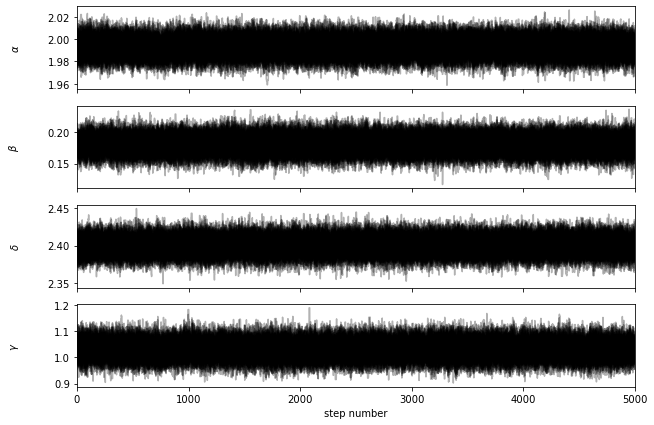

In [9]:
fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

labels = [r"$\alpha$", r"$\beta$", r"$\delta$", r"$\gamma$"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    #ax.plot(samples[:, 70:80, i])
    #ax.plot(samples[:, 80, i])
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

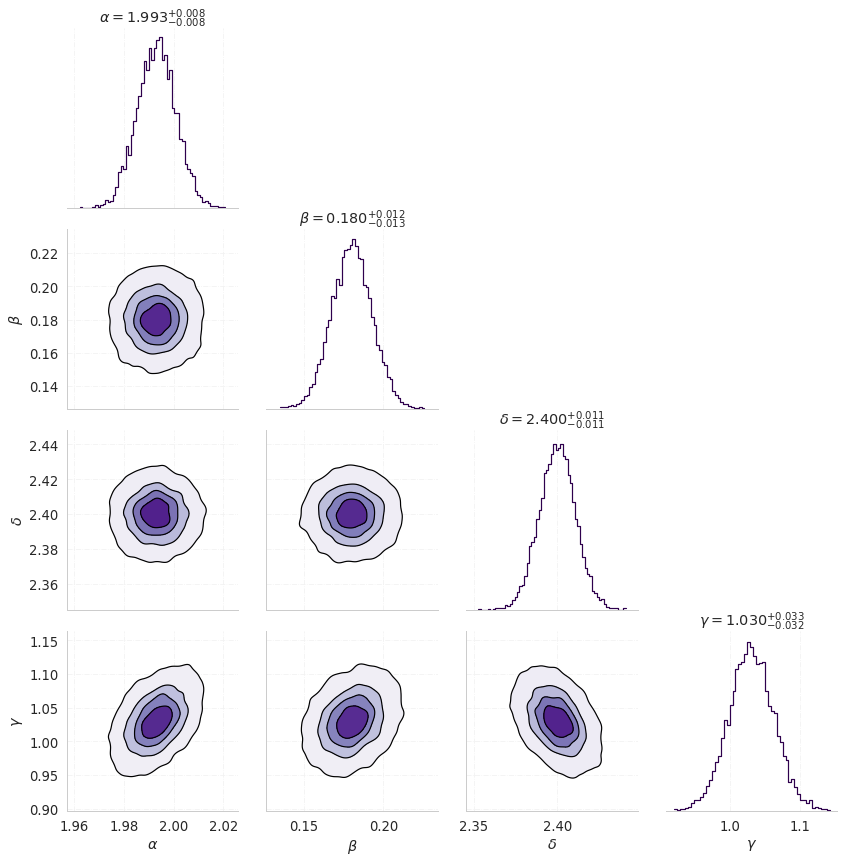

In [10]:
flat_samples = sampler.get_chain(discard=1000, thin=50, flat=True)

sns.set_style("whitegrid", { 'grid.color': '.95', 'grid.linestyle': '-.'})
sns.set_context("paper", font_scale=1.5)
g = sns.PairGrid(data = pd.DataFrame(flat_samples, columns = labels), corner = True, height = 3)  

g = g.map_diag(sns.histplot, element="step", fill=False, color = "#2e004d") # "#800060" goes w light purple / "#4c0080" goe w purple
g = g.map_lower(sns.kdeplot, 
                fill = True, 
                levels=5, 
                #shade=True,
                #color = "r", cmap = "Reds" #aceitavel
                #color = '#ffcccc' 
                #cmap = "light:magenta"#
                #cmap = "light:violet"
                #cmap = "light:purple"
                cmap = "Purples"
               ) 
g = g.map_lower(sns.kdeplot, 
                #fill = True, 
                levels=5, color = "Black")

for i in range(len(labels)):
    percentile =  np.percentile(flat_samples[:, i], [16, 50, 84])
    diff = np.diff(percentile)
    l = labels[i][:-1]  + " = {0:.3f}^{{+{1:.3f}}}_{{-{2:.3f}}}$".format(percentile[1], diff[1], diff[0])
    g.axes[i][i].set_title(l)



## Fiting Gamma

<AxesSubplot:xlabel='$\\gamma$', ylabel='Posterior'>

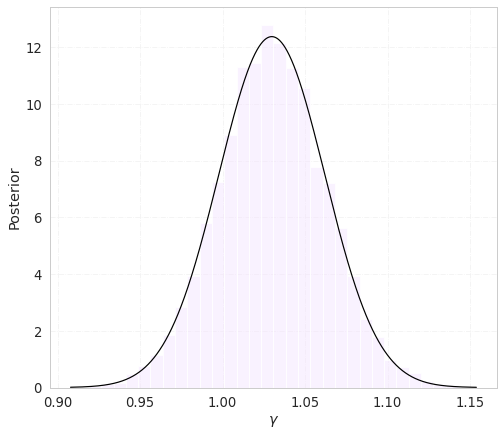

In [11]:
from scipy.optimize import curve_fit
def gaussian(x, mean, amplitude, s0):
    return amplitude * np.exp( - (x - mean)**2 /2./s0**2)

plt.figure(figsize= (8,7))
gamma = flat_samples[:, 3]
bins = 30
g = sns.histplot(gamma, bins=bins, alpha = .5, stat = "density", color = "#f5e6ff") #ffccf2
g.set_xlabel(r"$\gamma$")
g.set_ylabel(r"Posterior")

ax = g.get_children()
bin_height = []
bin_center = []
for i in range(bins):
    bin_height.append(ax[i].get_height())
    bin_center.append((ax[i].get_width()/2.0) + ax[i].get_x())

#sns.scatterplot(x = bin_center, y = bin_height, color = "black")  
popt, pcov = curve_fit(gaussian, bin_center, bin_height, p0=[1., 0., 1.])

x_interval_for_fit = np.linspace(g.get_xlim()[0], g.get_xlim()[1], 10000)
sns.lineplot(x = x_interval_for_fit, y = gaussian(x_interval_for_fit, *popt), color = "Black")

In [12]:
# mean and sd
from IPython.display import display, Math
print("This give us an estimation for an average value of \u03B3 an for its standard deviation:")

display(Math("\gamma_{PPN}" + " = {0:.3f}".format(popt[0])))
display(Math("\epsilon_{\gamma}" + "= {0:.3f}".format(abs(popt[2]))))


This give us an estimation for an average value of γ an for its standard deviation:


<IPython.core.display.Math object>

<IPython.core.display.Math object>